In [1]:
from optimization import optimize
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from oracle import Oracle, make_oracle
import seaborn as sns
from typing import List, Tuple
from sklearn.linear_model import LogisticRegression
from tabulate import tabulate

In [2]:
def optimize_sklearn(oracle):
    model = LogisticRegression(penalty="none", tol=1e-8, max_iter=10000, n_jobs=-1, fit_intercept=False)
    model.fit(oracle.X, oracle.Y.ravel())

    entropy_true = oracle.value(model.coef_.reshape(-1, 1))
    return entropy_true

In [3]:
def plot(data, true_ans: float, data_types: Tuple[str, List[str]], xaxis: str, title: str = None):
    fig, ax = plt.subplots(1, 2, figsize=(18, 8))

    for opt, params in data_types:
        if opt == "lbfgs":
            for hsize in params:
                data_to_plot = data[(data["OptMethod"] == opt) & (data["history_size"] == hsize)]
                ax[0].plot(data_to_plot[xaxis], np.log10(np.abs(data_to_plot.entropy - true_ans)), label=f"{opt}:{hsize}")
                ax[1].plot(data_to_plot[xaxis], np.log10(data_to_plot.rk), label=f"{opt}:{hsize}")
        else:
            for ls in params:
                data_to_plot = data[(data["OptMethod"] == opt) & (data["LineSearch"] == ls)]
                ax[0].plot(data_to_plot[xaxis], np.log10(np.abs(data_to_plot.entropy - true_ans)), label=f"{opt}:{ls}")
                ax[1].plot(data_to_plot[xaxis], np.log10(data_to_plot.rk), label=f"{opt}:{ls}")

    plt.suptitle(title, y=1.02)
    ax[0].set_ylabel("$\log(|F(w*) - F(w_{true})|)$")
    ax[1].set_ylabel("$\log\\left(\\frac{|\Delta F(w_k)|}{|\Delta F(w_0)|}\\right)$")

    if xaxis == "num_iter":
        xlabel = "Iteration number"
    elif xaxis == "oracle_calls":
        xlabel = "Oracle calls"
    else:
        xlabel = "Time, s"

    ax[0].set_xlabel(xlabel)
    ax[1].set_xlabel(xlabel)

    handles, labels = ax[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper center", ncol=6, bbox_to_anchor=(0.5, 0.97))
    plt.show()

In [4]:
hsizes = list(range(10, 101, 10))

In [5]:
a1a = make_oracle("a1a.libsvm")
true_ans = optimize_sklearn(a1a)

In [6]:
sns.set()
sns.set_context("talk")
linesearch_methods = ["wolfe"]

In [7]:
max_iter = 10000
tol = 1e-8
w0 = np.ones((a1a.m, 1)) * 0

to_df = []
for hsize in hsizes:
    _, _, log = optimize(w0, a1a, "lbfgs", "wolfe", max_iter=max_iter, output_log=True, tol=tol, history_size=hsize)
    to_df.append(log.dataframe)

_, _, log = optimize(w0, a1a, "newton", "armijo", output_log=True)
to_df.append(log.dataframe)

_, _, log = optimize(w0, a1a, "cg", "armijo", max_iter=max_iter, output_log=True, tol=tol)
to_df.append(log.dataframe)

data = pd.concat(to_df, ignore_index=True)

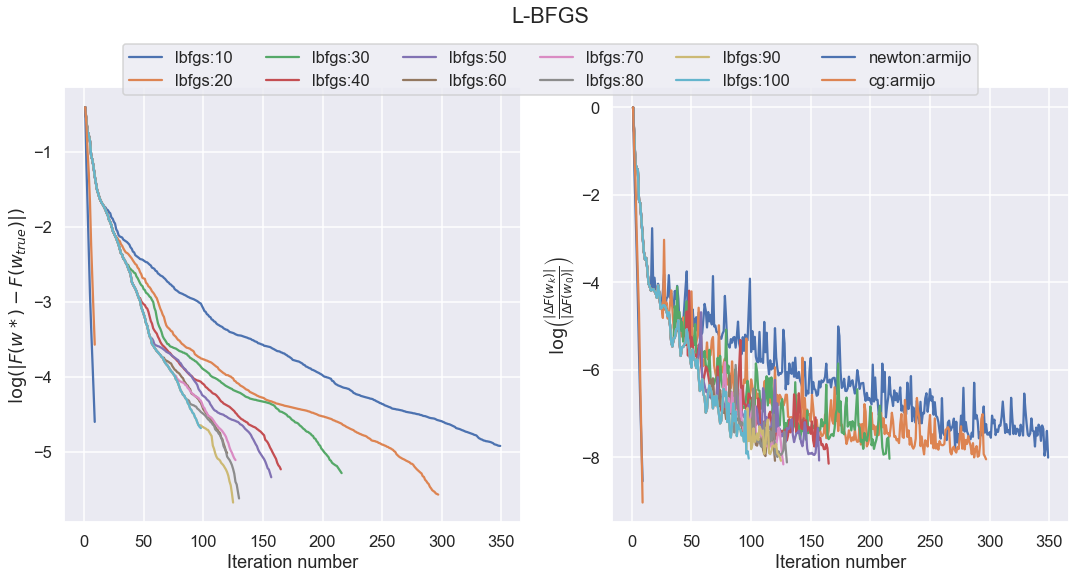

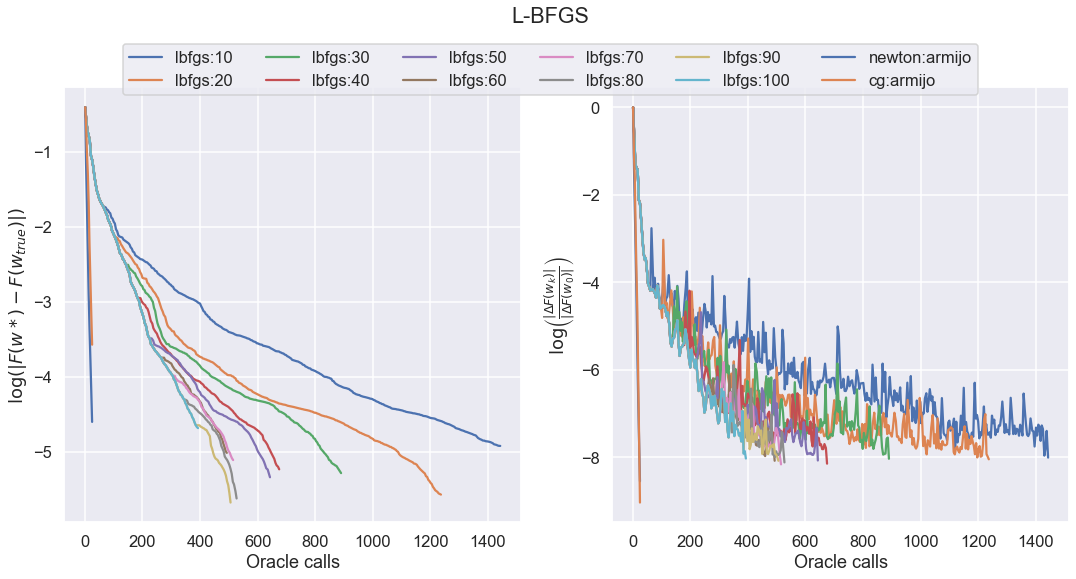

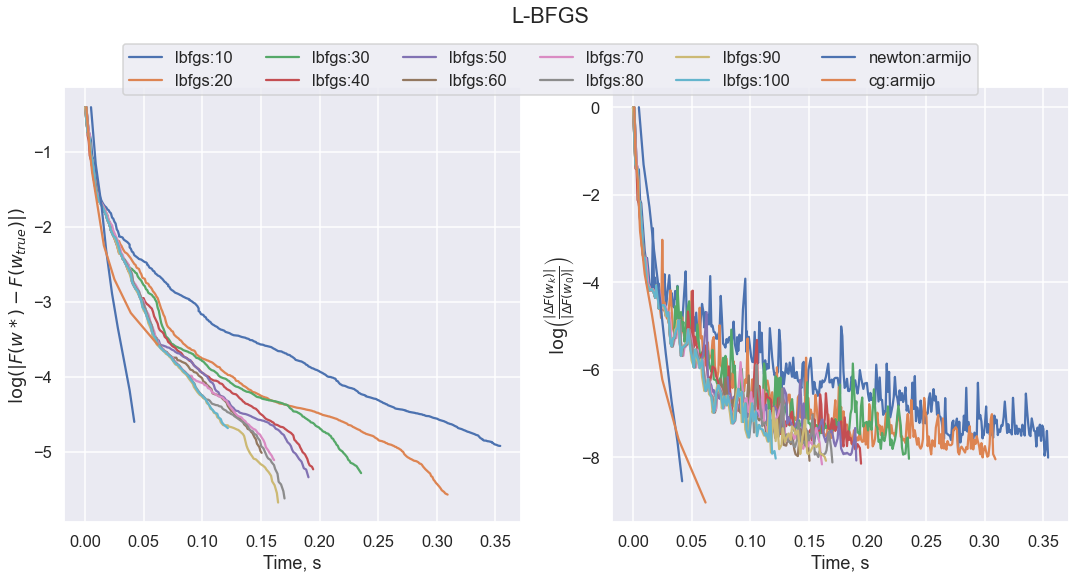

In [8]:
plot(data, true_ans, [("lbfgs", hsizes), ("newton", ["armijo"]), ("cg", ["armijo"])], "num_iter", "L-BFGS")
plot(data, true_ans, [("lbfgs", hsizes), ("newton", ["armijo"]), ("cg", ["armijo"])], "oracle_calls", "L-BFGS")
plot(data, true_ans, [("lbfgs", hsizes), ("newton", ["armijo"]), ("cg", ["armijo"])], "time", "L-BFGS")

По графикам видно, что `lbfgs` работает несколько похуже во всех отношениях, если сравнивать с методами Ньютона и сопряженных градиентов.

Правда, странно, что у меня сопряженные градиенты начали отрабатывать почти как Ньютон, хотя, вроде бы, ничего существенного в коде не менялось с прошлого дз. Глобально, я ожидал, что `lbfgs` отработает очень похоже на метод сопряженных градиентов, но обозначенную загадку (странного ускорения `cg`), к сожалению, разрешить не успел к дедлайну.

In [9]:
bc = make_oracle("breast-cancer_scale.libsvm")
true_ans = optimize_sklearn(bc)

In [10]:
max_iter = 10000
tol = 1e-8
w0 = np.ones((bc.m, 1)) * 0

to_df = []
for hsize in hsizes:
    _, _, log = optimize(w0, bc, "lbfgs", "wolfe", max_iter=max_iter, output_log=True, tol=tol, history_size=hsize)
    to_df.append(log.dataframe)

_, _, log = optimize(w0, bc, "newton", "armijo", max_iter=max_iter, output_log=True, tol=tol)
to_df.append(log.dataframe)

_, _, log = optimize(w0, bc, "cg", "armijo", max_iter=max_iter, output_log=True, tol=tol)
to_df.append(log.dataframe)

_, _, log = optimize(w0, bc, "gd", "armijo", max_iter=max_iter, output_log=True, tol=tol)
to_df.append(log.dataframe)

data = pd.concat(to_df, ignore_index=True)

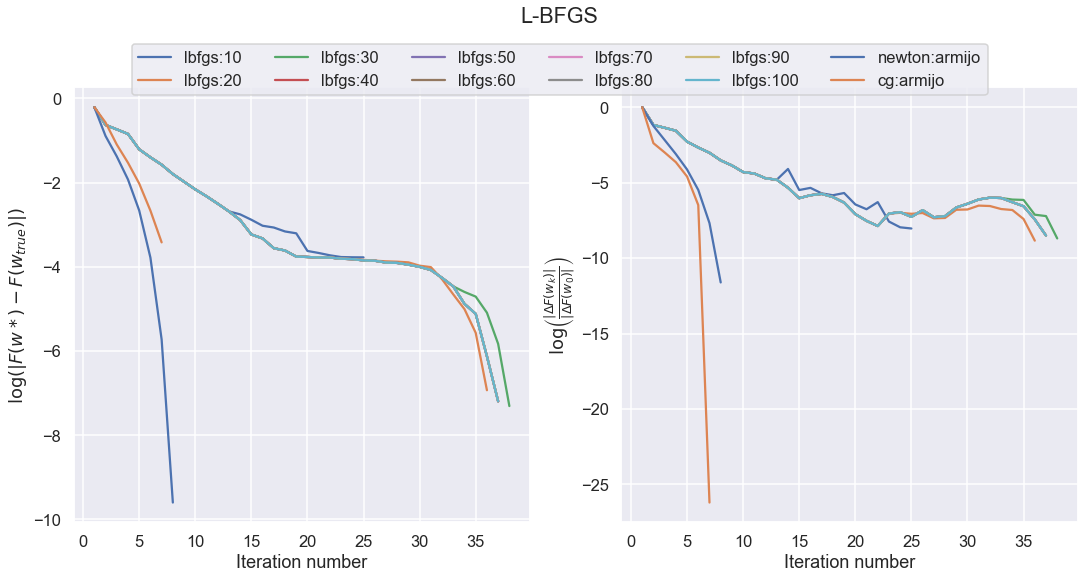

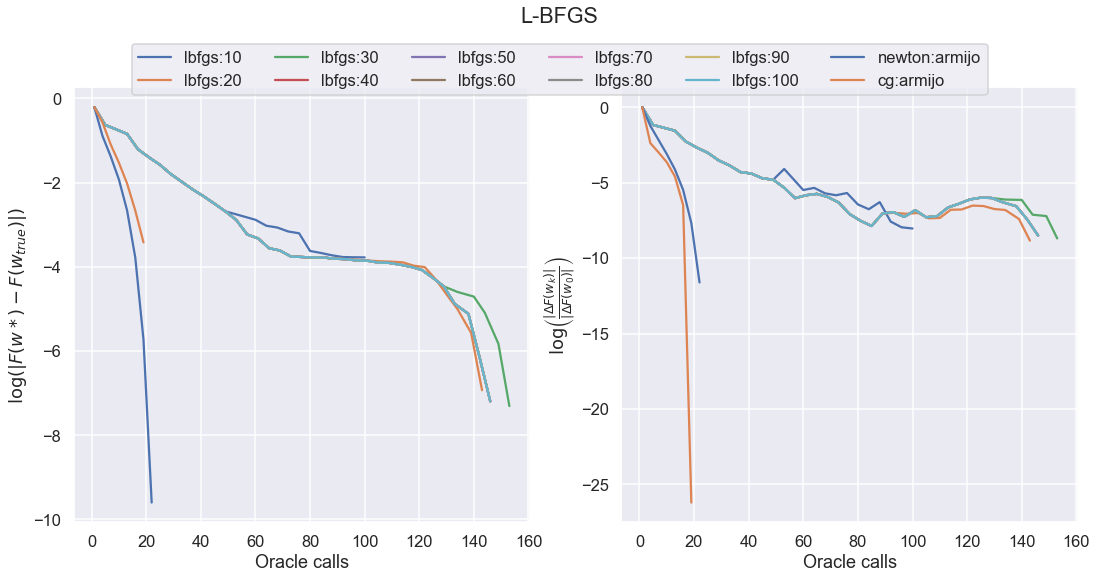

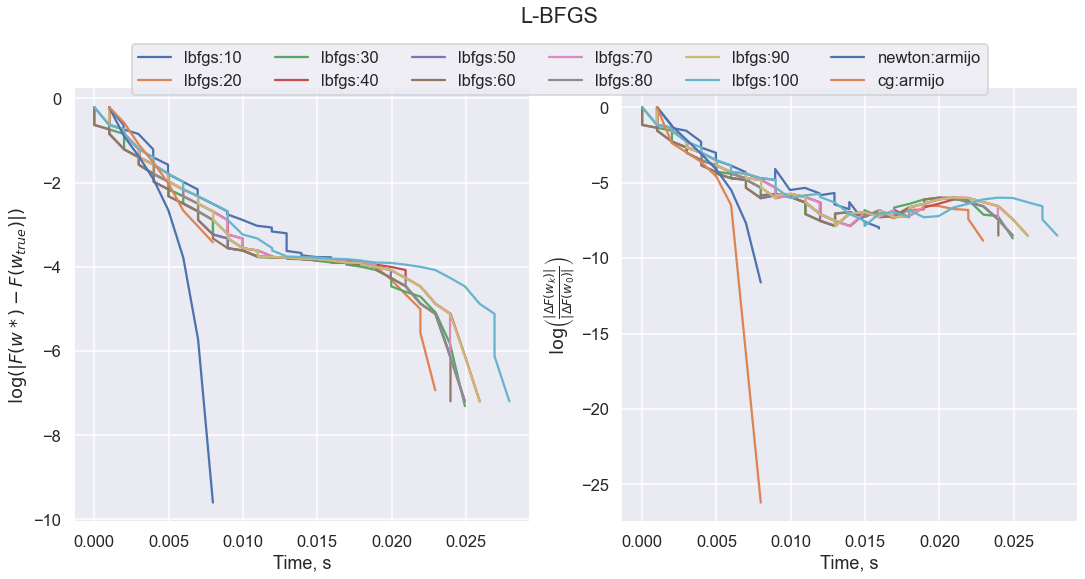

In [11]:
plot(data, true_ans, [("lbfgs", hsizes), ("newton", ["armijo"]), ("cg", ["armijo"])], "num_iter", "L-BFGS")
plot(data, true_ans, [("lbfgs", hsizes), ("newton", ["armijo"]), ("cg", ["armijo"])], "oracle_calls", "L-BFGS")
plot(data, true_ans, [("lbfgs", hsizes), ("newton", ["armijo"]), ("cg", ["armijo"])], "time", "L-BFGS")

В целом, сравнение между методами здесь такое же, как и для `a1a` датасета. Правда, стоит заметить, что `lbfgs` иногда приунывает и "отдыхает" на плато некоторое время, а потом опять начинает сходится. При этом занятно, что если к "точному" ответу мы приближаемся, то на графике отношения норм градиентов виден явный горб после плато.

Дополнительно, замечу, что странное поведение метода сопраженных градиентов на этом датасете еще страннее: с одной стороны у нас резко и очень сильно различаются градиенты в начале и в конце итераций (графики справа), но при этом этот метод не достигает "точного" ответа с такой же точностью, как, например, метод Ньютона.

Кажется, что что-то где-то нарушилось в коде, потому что на прошлой дз этот метод показывал вполне прогнозируемое и ожидаемое от него поведение, а сейчас что-то явно пошло не так. Повторюсь, при этом существенных изменений код не претерпевал (даже не уверен, что были хоть какие-то изменения в этой части).

P.S. простите за два оранжевых цвета :(